Bachelor thesis - Richard Borschke - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types Based On Centrality And Duration

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling via MinMaxScaler
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [15]:
import pandas as pd
import glob

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme(style="white")

from sklearn.preprocessing import MinMaxScaler


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

import time
# import numpy as np

### Load Data

In [16]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [17]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [18]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [19]:
# select only dist features (based on manuelly defined trip types in literature) and id + vehicleType for later interpretation
#dfWARNING = data_full[['id','vehicleType','dist_center_start','dist_center_end']]
#df = dfWARNING.sample(n=100000, random_state=1)

df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration']].copy()
df['duration'] = df['duration'] / 60
df.columns

Index(['id', 'vehicleType', 'dist_center_start', 'dist_center_end',
       'duration'],
      dtype='object')

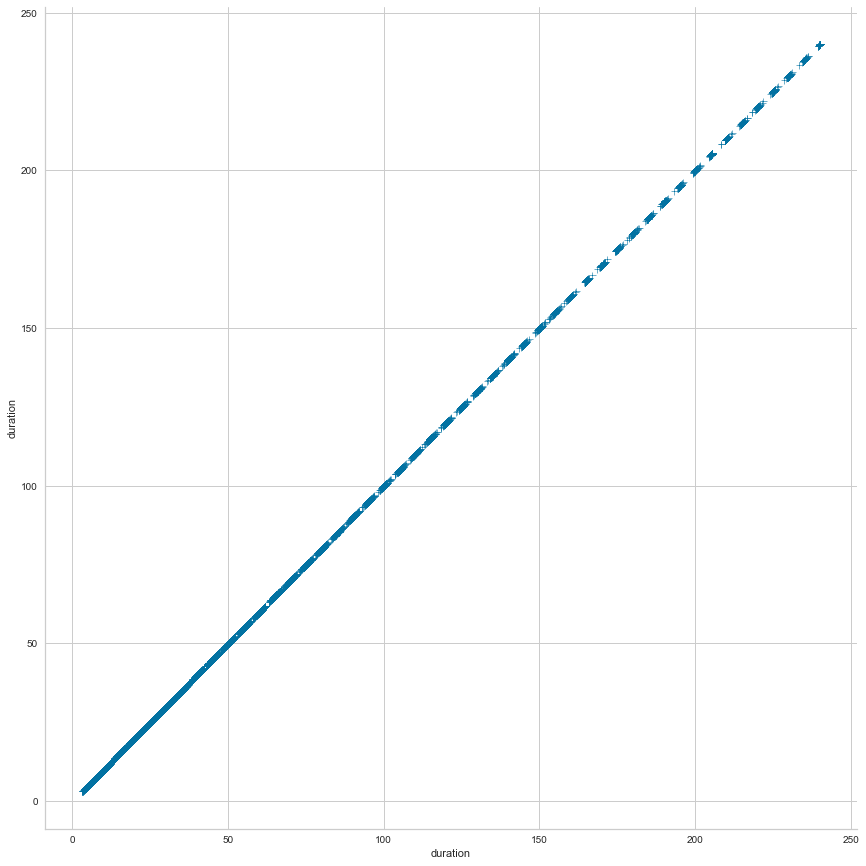

In [20]:
# plot features to visually observe structure of data
g = sns.relplot(x="duration", y="duration", kind="scatter", data=df, marker='+', height=12, aspect=1)

In [65]:
df['duration'].max()

110.46666666666667

In [63]:
from scipy.stats import zscore
import numpy as np

# remove extreme outliers
# data values that have a z-score sigma greater than a threshold of 4, are declared to be outliers.
z_scores = zscore(df[['dist_center_start','dist_center_end','duration']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
df = df[filtered_entries]
df


#df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)]

# plot indicates four interpretable convex clusters
#g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=12, aspect=1)




,id,vehicleType,dist_center_start,dist_center_end,duration
0,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzE5MTQy,car,5055,4787,9.916667
1,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzIxNTM2,car,486,948,19.950000
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzcyNDA3,car,2049,4820,19.950000
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkwNTc5,car,2943,3727,24.933333
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzNjQy,car,5268,2697,24.933333
...,...,...,...,...,...
404858,YmlrZTo6dGllcjo6YTFlMmYzZjEtNjkyZS00NjA4LWE5YT...,scooter,179,382,10.000000
404859,YmlrZTo6dGllcjo6OGUxYjAwNDUtMDY3NS00Mzc4LTk3Yz...,scooter,3602,4204,15.033333
404860,YmlrZTo6dGllcjo6ZGE1NmNkMDgtN2Q5ZS00YzE0LWI2OT...,scooter,2007,3149,15.033333
404861,YmlrZTo6dGllcjo6NzRlY2JjZTYtZWQ3Yi00ZGY3LWJmMG...,scooter,2801,2958,5.000000


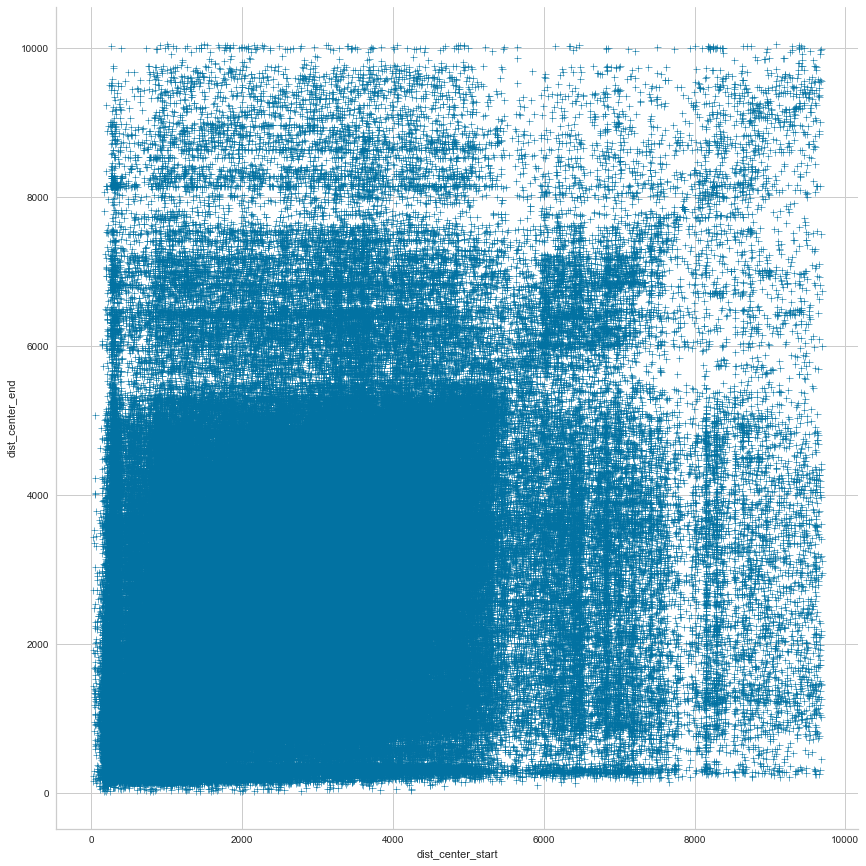

In [64]:
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=12, aspect=1)

### Feature scaling

(array([0, 1, 2]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration')])

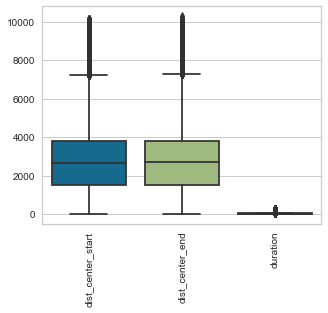

In [8]:
# look at feature skewness
plt.figure(figsize=(5,4))
sns.boxplot(data=df)
plt.xticks(rotation=90)

In [9]:
df_minmax = df[['dist_center_start','dist_center_end', 'duration']].copy()

# save names
names = df_minmax.columns

# scale data
scaler = MinMaxScaler()
scaler.fit(df_minmax)
df_minmax = scaler.transform(df_minmax)

# convert scaled array into dataframe
scaled_df = pd.DataFrame(df_minmax, columns=names) 

scaled_df

,dist_center_start,dist_center_end,duration
0,0.497973,0.464763,0.028911
1,0.046268,0.090555,0.071258
2,0.200791,0.467979,0.071258
3,0.289174,0.361439,0.092290
4,0.519031,0.261039,0.092290
...,...,...,...
401617,0.015917,0.035384,0.029263
401618,0.354325,0.407934,0.050506
401619,0.196639,0.305098,0.050506
401620,0.275136,0.286480,0.008160


(array([0, 1, 2]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration')])

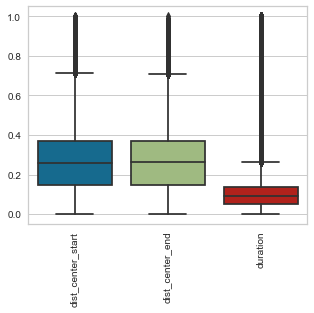

In [10]:
# visualize scaled features (still right skewed but scaled from 0 to 1 + 0 remains)
plt.figure(figsize=(5,4))
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)

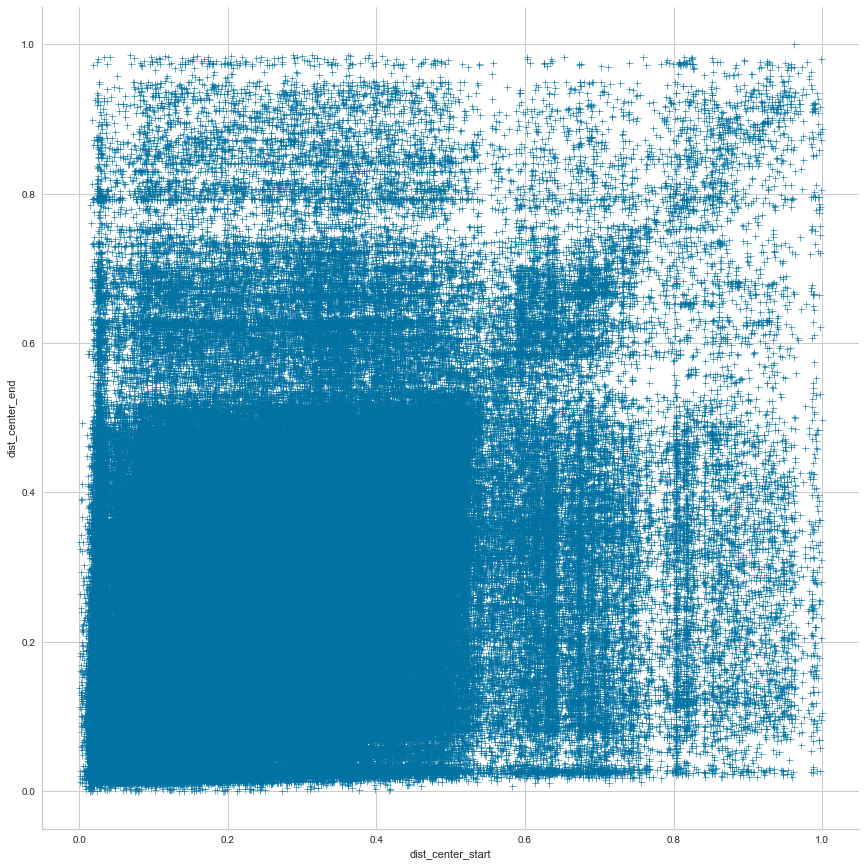

In [11]:
# plot still indicates four interpretable convex clusters
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=scaled_df, marker='+', height=12, aspect=1)

### Cluster Tendency

In [12]:
from pyclustertend import hopkins
hopkins(scaled_df, 10000)

0.08984544788126612

### Clustering trip types via k-means and parameter selection

In [13]:
# run k-means multiple times to identify "optimal" k

# with-in cluster sum of squares
wcss=[]

# run loop
for i in range (1,15):   
    start = time.time()
    kmeans = KMeans(i)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)
    end = time.time()
    print(i)
    print(end - start)

1
0.9250526428222656
2
3.3420631885528564
3
12.72055196762085
4
15.379457235336304
5
22.054031133651733
6
28.419127464294434
7
20.81696844100952
8
30.598710775375366
9
37.348822355270386
10
47.092750787734985
11
57.54717516899109
12
59.959227323532104
13
82.62664484977722
14
90.62050461769104


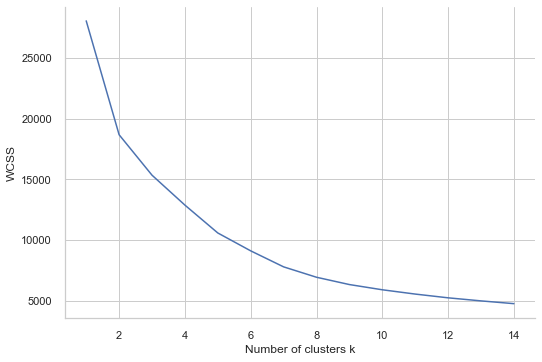

In [14]:
# plot elbow plot to visually pick "optimal" k
sns.set_theme(style="whitegrid")
g = sns.relplot(x=range(1,15), y=wcss, kind="line", height=5, aspect=1.5)
g.set_axis_labels('Number of clusters k', 'WCSS')

In [16]:
# silhouette score EXTREMELY high running time
if (False):
    model = KMeans(random_state=0)

    # select range of cluster number and the metric to observe costs
    visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)

    # fit and visualize
    visualizer.fit(scaled_df)    
    visualizer.poof()

In [17]:
# cluster data for the chosen number of clusters
k = 8
k_means_new = KMeans(k)

kmeans.fit(scaled_df)

clustered_data = df.copy()
clustered_data['cluster'] = k_means_new.fit_predict(scaled_df)

clustered_data

,id,vehicleType,dist_center_start,dist_center_end,duration,cluster
0,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzE5MTQy,car,5055,4787,9.916667,3
1,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzIxNTM2,car,486,948,19.950000,1
2,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzcyNDA3,car,2049,4820,19.950000,5
3,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkwNTc5,car,2943,3727,24.933333,3
4,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzNjQy,car,5268,2697,24.933333,3
...,...,...,...,...,...,...
404858,YmlrZTo6dGllcjo6YTFlMmYzZjEtNjkyZS00NjA4LWE5YT...,scooter,179,382,10.000000,1
404859,YmlrZTo6dGllcjo6OGUxYjAwNDUtMDY3NS00Mzc4LTk3Yz...,scooter,3602,4204,15.033333,3
404860,YmlrZTo6dGllcjo6ZGE1NmNkMDgtN2Q5ZS00YzE0LWI2OT...,scooter,2007,3149,15.033333,5
404861,YmlrZTo6dGllcjo6NzRlY2JjZTYtZWQ3Yi00ZGY3LWJmMG...,scooter,2801,2958,5.000000,5


### Interpretation and visualization of results

* cluster: inner-inner trips
* cluster: outer-outer trips
* cluster: outer-inner trips
* cluster: inner-outer trips

In [18]:
# show cluster results for interpretation
clustered_data.groupby(['cluster']).describe()

dist_center_start                                                     \
                    count         mean          std     min      25%     50%   
cluster                                                                        
0                 76234.0  3458.571661   733.827134  1739.0  2881.00  3351.0   
1                 98065.0  1253.625493   586.595042    18.0   850.00  1228.0   
2                 18052.0  2529.981166  1172.668619   142.0  1581.75  2586.0   
3                 85528.0  3874.992891   681.718747  2459.0  3322.00  3773.0   
4                 12940.0  2975.316306  1499.665623    49.0  1844.75  2924.0   
5                 82463.0  1736.157549   693.667814    18.0  1211.00  1829.0   
6                 10902.0  6672.391855  1319.891468  4490.0  5716.00  6461.0   
7                 17438.0  6996.704209  1138.653351  4832.0  6189.00  6779.0   

                          dist_center_end               ...                    \
             75%      max           count         mean  ...      75%      max   
cluster                                                 ...                     
0        3938.00   5688.0         76234.0  1696.652386  ...  2279.00   3097.0   
1        1697.00   2678.0         98065.0  1268.025840  ...  1739.00   2697.0   
2        3485.25   4945.0         18052.0  6970.188843  ...  7543.00  10134.0   
3        4354.00   6115.0         85528.0  3908.202542  ...  4413.00   6129.0   
4        3921.00   9761.0         12940.0  3003.737481  ...  3930.25  10024.0   
5        2311.00   3031.0         82463.0  3437.139153  ...  3903.00   5713.0   
6        7416.00  10129.0         10902.0  6663.160704  ...  7408.75  10278.0   
7        7601.00  10133.0         17438.0  2492.369366  ...  3495.75   5113.0   

        duration                                                            \
           count        mean        std        min         25%         50%   
cluster                                                                      
0        76234.0   29.265697  15.328018   4.100000   19.966667   25.050000   
1        98065.0   17.274199  12.497188   3.066667   10.000000   14.983333   
2        18052.0   39.200275  19.256074   4.716667   25.283333   35.000000   
3        85528.0   24.378095  15.791857   3.166667   10.250000   20.016667   
4        12940.0  137.938044  41.808540  79.650000  104.983333  125.016667   
5        82463.0   27.672049  14.897463   3.333333   15.300000   25.000000   
6        10902.0   32.212888  26.847837   4.066667   15.000000   25.000000   
7        17438.0   40.811799  19.731073   4.950000   29.950000   35.016667   

                                 
                75%         max  
cluster                          
0         35.033333   99.983333  
1         20.016667  104.983333  
2         45.000000  189.983333  
3         34.700000   91.416667  
4        165.000000  240.000000  
5         35.000000   95.266667  
6         40.000000  240.000000  
7         45.366667  185.016667  

[8 rows x 24 columns]

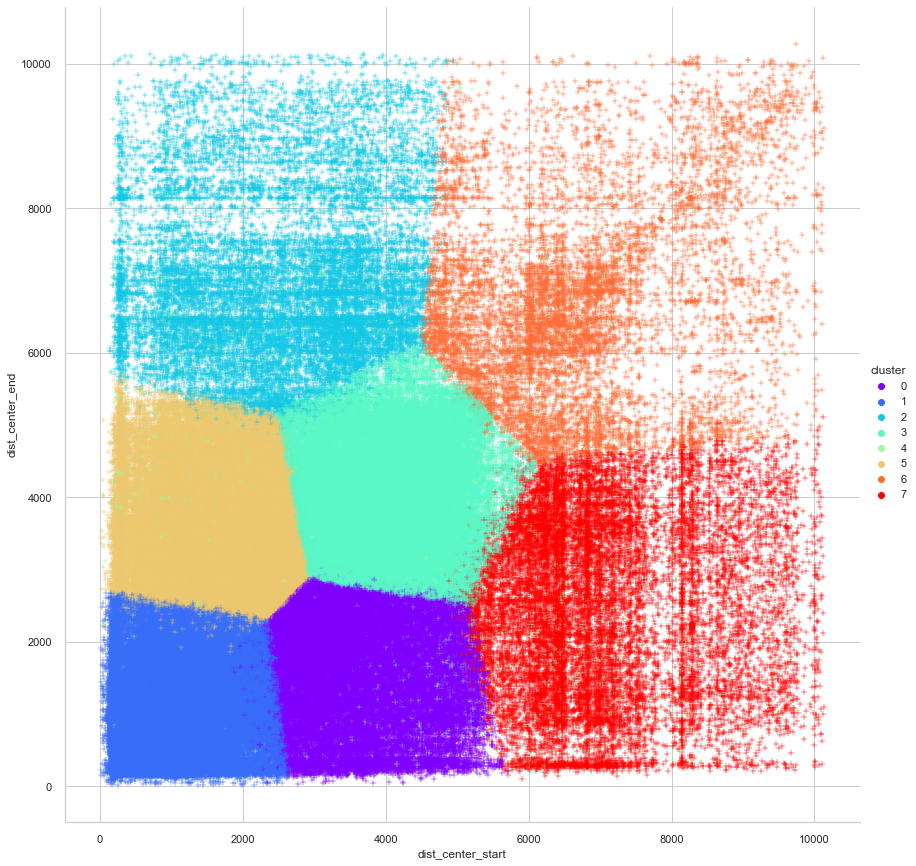

In [26]:
# plot cluster results
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=clustered_data, legend='full', marker='+', hue='cluster', palette='rainbow', height=12, aspect=1)

### Distribution of trip types among mobility modes

In [20]:
# show cluster distribution
clustered_data.groupby(['vehicleType','cluster']).describe()

dist_center_start                                    \
                                count         mean          std     min   
vehicleType cluster                                                       
bicycle     0                  5706.0  3138.512443   533.279961  1809.0   
            1                  8148.0  1347.934585   598.852327    18.0   
            2                   139.0  2745.935252  1055.115676   142.0   
            3                  4168.0  3612.963292   547.765899  2595.0   
            4                   845.0  2489.820118  1017.455825    49.0   
            5                  6276.0  1931.147865   653.620024    18.0   
            6                    85.0  6124.694118   903.395882  4579.0   
            7                   134.0  6268.992537   672.918160  4891.0   
car         0                 55028.0  3582.382587   758.075012  1739.0   
            1                 22844.0  1372.688934   601.008918    41.0   
            2                 17324.0  2526.271877  1176.989109   144.0   
            3                 53242.0  3930.258931   709.304835  2486.0   
            4                 11932.0  3025.142390  1519.067037   155.0   
            5                 56016.0  1641.108219   701.526366   117.0   
            6                  8964.0  6791.169232  1392.521200  4490.0   
            7                 16987.0  7019.579031  1141.421799  4832.0   
scooter     0                 15500.0  3136.842000   554.993846  1872.0   
            1                 67073.0  1201.617745   572.621650    23.0   
            2                   589.0  2588.117148  1061.790282   160.0   
            3                 28118.0  3809.186820   629.466527  2459.0   
            4                   163.0  1844.760736  1260.415911    75.0   
            5                 20171.0  1939.445640   623.947709    48.0   
            6                  1853.0  6122.922828   669.660795  4540.0   
            7                   317.0  6078.529968   471.314587  5240.0   

                                                       dist_center_end  \
                         25%     50%      75%      max           count   
vehicleType cluster                                                      
bicycle     0        2714.00  3092.0  3472.00   5130.0          5706.0   
            1         921.00  1330.5  1842.25   2640.0          8148.0   
            2        1952.00  3059.0  3617.00   4568.0           139.0   
            3        3211.75  3493.0  3958.25   6073.0          4168.0   
            4        1654.00  2571.0  3236.00   6078.0           845.0   
            5        1487.75  2015.0  2484.00   2999.0          6276.0   
            6        5821.00  6188.0  6376.00   9222.0            85.0   
            7        5873.00  6183.5  6372.75   9267.0           134.0   
car         0        2985.00  3507.0  4138.00   5688.0         55028.0   
            1         931.00  1372.0  1871.00   2678.0         22844.0   
            2        1570.75  2580.0  3486.25   4945.0         17324.0   
            3        3351.00  3855.0  4486.00   6115.0         53242.0   
            4        1883.50  2976.0  4004.00   9761.0         11932.0   
            5        1090.00  1687.0  2225.00   3031.0         56016.0   
            6        5688.00  6678.0  7740.50  10129.0          8964.0   
            7        6211.00  6808.0  7634.50  10133.0         16987.0   
scooter     0        2716.00  3019.0  3452.00   5629.0         15500.0   
            1         805.00  1166.0  1612.00   2667.0         67073.0   
            2        1851.00  2698.0  3449.00   4564.0           589.0   
            3        3307.00  3704.0  4215.00   6088.0         28118.0   
            4         912.50  1525.0  2630.00   5279.0           163.0   
            5        1520.00  2078.0  2426.00   3010.0         20171.0   
            6        5742.00  6039.0  6472.00   9926.0          1853.0   
            7        5794.00  5989.0  6311.00   8094.0           317.0

In [21]:
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['cluster']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution [%]'] = distribution['id'] / trip_volume *100

    return distribution[['Distribution [%]']]

In [22]:
create_distribution_overview('car')

,Distribution [%]
cluster,
0,22.707222
1,9.426542
2,7.148723
3,21.970232
4,4.923722
5,23.114918
6,3.698981
7,7.009660


In [23]:
create_distribution_overview('bicycle')

,Distribution [%]
cluster,
0,22.375593
1,31.951688
2,0.545077
3,16.344457
4,3.313596
5,24.610800
6,0.333320
7,0.525470


In [24]:
create_distribution_overview('scooter')

,Distribution [%]
cluster,
0,11.585840
1,50.135293
2,0.440262
3,21.017461
4,0.121838
5,15.077289
6,1.385068
7,0.236949
